In [1]:
import numpy as np
from matplotlib import pyplot as plt

import torch
from sklearn.cluster import DBSCAN
from torch_geometric.data import Data
import torch_geometric.transforms as ttr

from mptd.simple_message import SimpleMessage

In [2]:
class MPTDData(Data):
    """
    Represents the data for Message-Passing Transient Detection (MPTD).

    Parameters
    ----------
    x : None
        Feature data (not used in this context).
    edge_index : None
        Graph edge indices (not used in this context).
    edge_attr : None
        Graph edge attributes (not used in this context).
    y : None
        Target labels (not used in this context).
    pos : torch.Tensor
        Tensor representing the node positions (coordinates).
    **kwargs
        Additional keyword arguments.

    Returns
    -------
    MPTDData
        A new instance of MPTDData with the given node positions.

    Raises
    ------
    ValueError
        If the data object has no valid tensor for indexing.
    """

    def __init__(self, x=None, edge_index=None, edge_attr=None, y=None, pos=None, **kwargs):
        assert x is None
        super().__init__(x, edge_index, edge_attr, y, pos, **kwargs)

    @property
    def x(self):
        """
        Get the node positions (coordinates) stored in 'pos' attribute.

        Returns
        -------
        torch.Tensor
            Node positions (coordinates).
        """
        return self.pos

In [3]:
def plot_graph(data, sizes, title, plot_edges=True, outfile=None):
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    # Plot the edges
    if plot_edges:
        for i in range(data.edge_index.size(1)):
            x_start, y_start = data.x[data.edge_index[0, i]].cpu()
            x_end, y_end = data.x[data.edge_index[1, i]].cpu()
            ax.plot([x_start, x_end], [y_start, y_end], color='blue', alpha=0.3)

    issimulated = data.y.squeeze().cpu().bool()

    # Plot the background points
    bkg_data = data.pos[~issimulated].cpu()
    bkg_sizes = sizes[~issimulated].cpu()
    ax.scatter(bkg_data[:,0], bkg_data[:,1],c="blue", alpha=0.8, label="background", s=bkg_sizes)

    # Plot the gaussian points
    sim_data = data.pos[issimulated].cpu()
    sim_sizes = sizes[issimulated].cpu()
    ax.scatter(sim_data[:,0], sim_data[:,1], c="red", alpha=0.8, label="simulated", s=sim_sizes)

    # Set axis labels
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    # Set plot title
    ax.set_title(title)

    # Add a legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)
    plt.tight_layout()
    if outfile:
        plt.savefig(outfile)
    plt.show()

In [4]:
k=4
model = SimpleMessage()
transformer = ttr.KNNGraph(k=k, force_undirected=True)

In [5]:
seed = 42  # Example seed value, adjust as needed
device="cpu"#"cuda:0"
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

num_uniform_points = 100  # Example value, adjust as needed
points = torch.empty(num_uniform_points, 3, device=device).uniform_(-1, 1)
points[:,2] = 0

var_x = 0.025  # Example value, adjust as needed
var_y = 0.05  # Example value, adjust as needed

num_gaussian_points = 10  # Example value, adjust as needed

gaussian_points = torch.empty(num_gaussian_points, 3, device=device)
gaussian_points[:, 0].normal_(0, var_x)
gaussian_points[:, 1].normal_(0, var_y)
gaussian_points[:, 2] = 1

points = torch.vstack([points, gaussian_points])

gaussian_points = torch.empty(num_gaussian_points, 3, device=device)
gaussian_points[:, 0].normal_(0.5, var_x)
gaussian_points[:, 1].normal_(-0.5, var_y)
gaussian_points[:, 2] = 1

points = torch.vstack([points, gaussian_points])

gaussian_points = torch.empty(num_gaussian_points, 3, device=device)
gaussian_points[:, 0].normal_(-0.5, var_x)
gaussian_points[:, 1].normal_(0.5, var_y)
gaussian_points[:, 2] = 1

points = torch.vstack([points, gaussian_points])

In [6]:
data = MPTDData(pos=points[:,:2], y=points[:,2].unsqueeze(-1))
net_data = transformer(data)
distances = torch.norm(net_data.pos[net_data.edge_index[0]] - net_data.pos[net_data.edge_index[1]], dim=1)

In [7]:
plot_edges=False
layers=30
plot_every=1

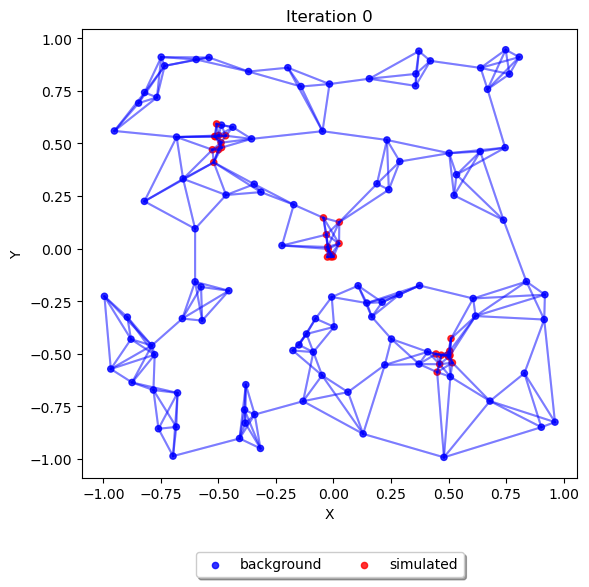

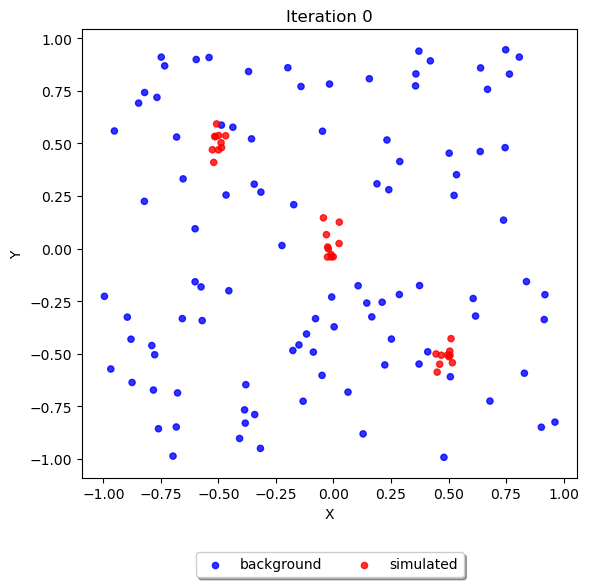

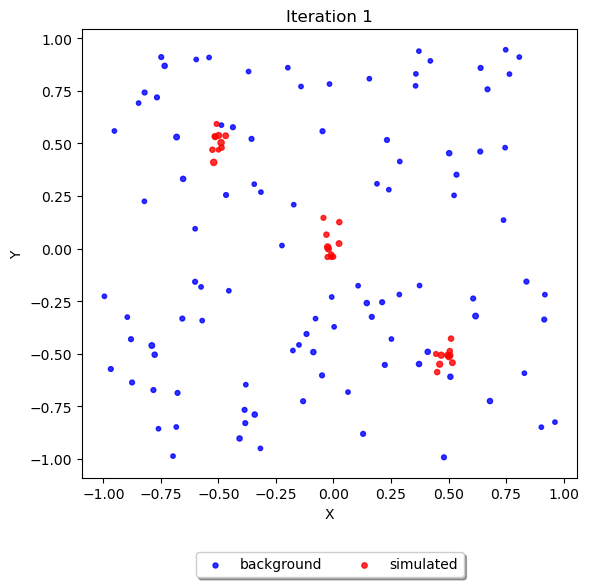

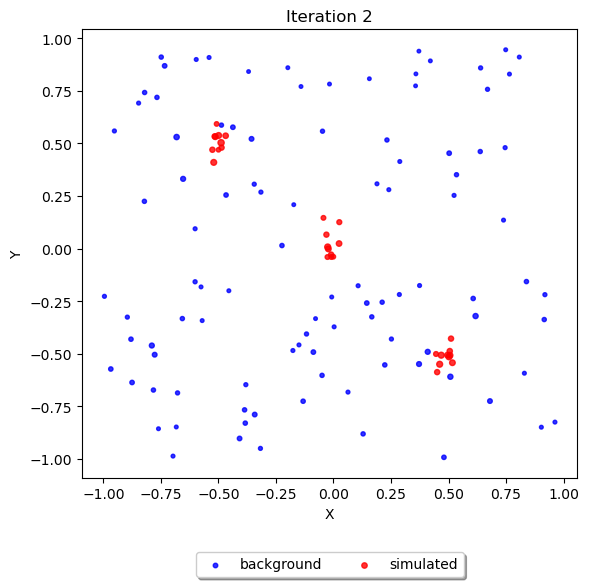

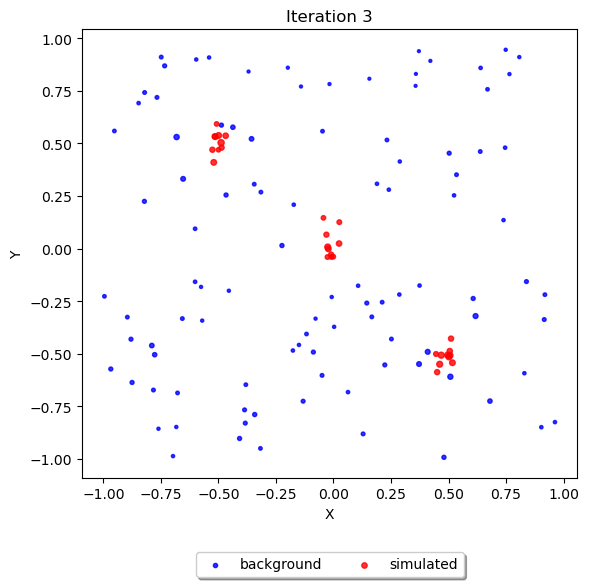

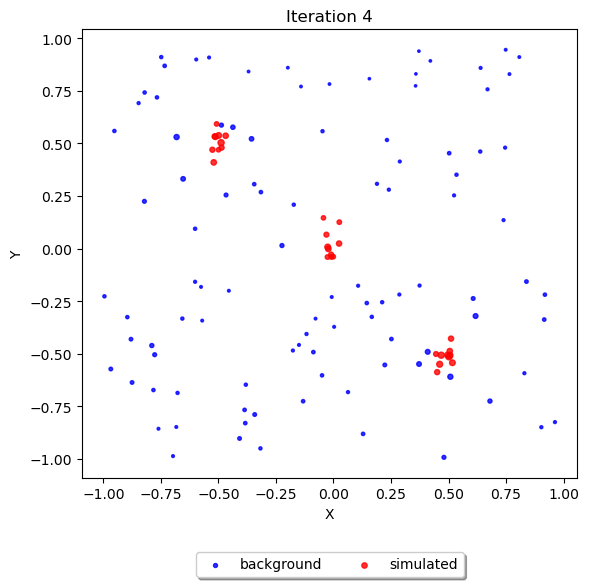

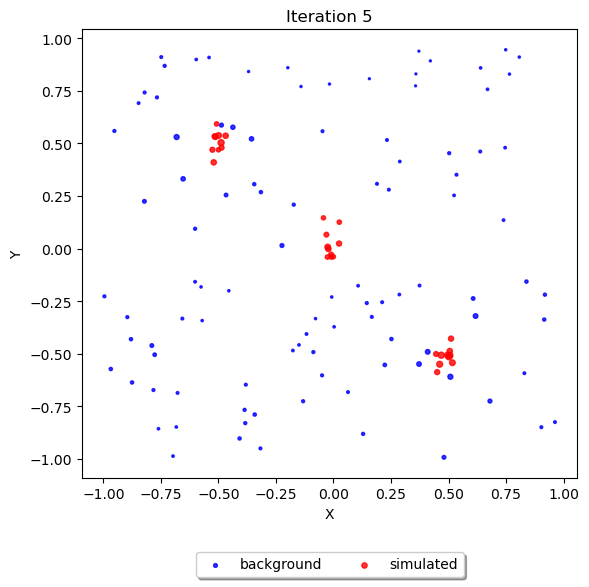

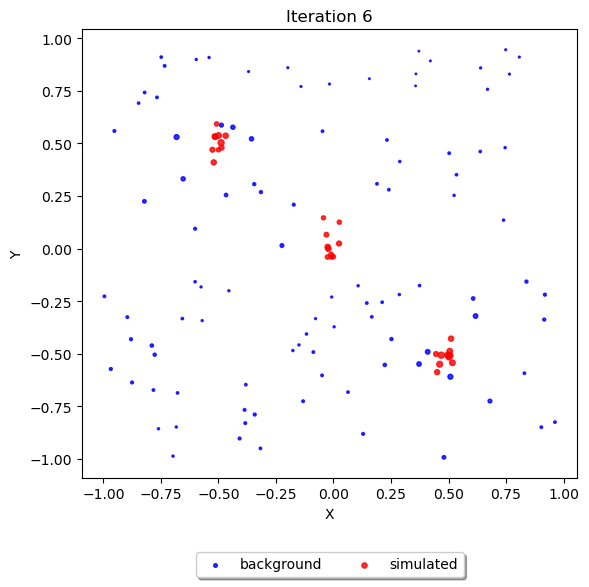

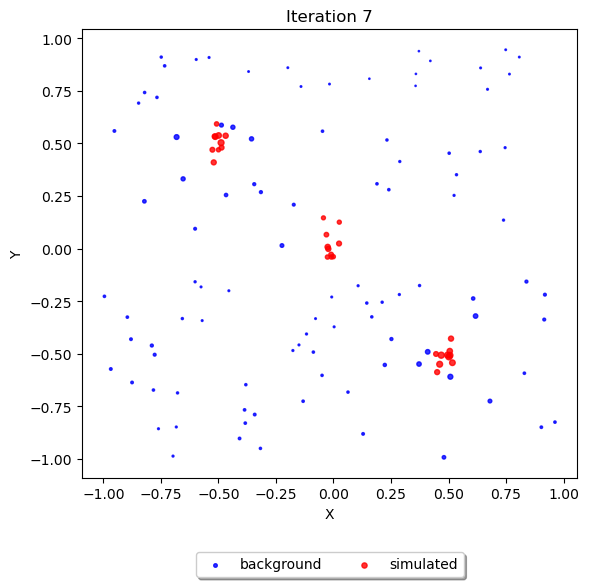

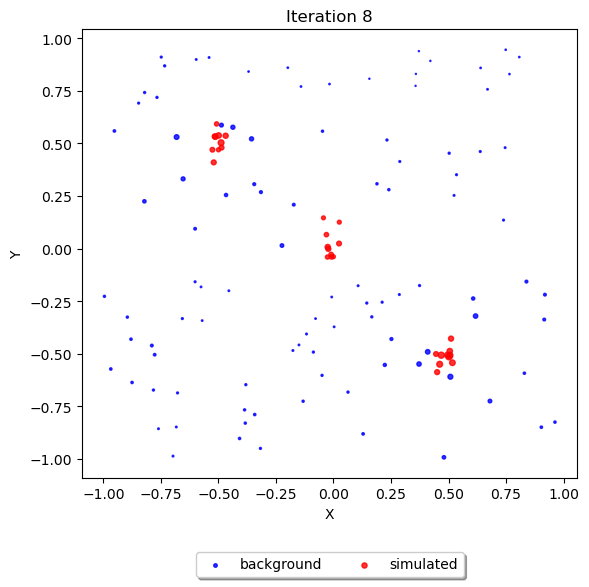

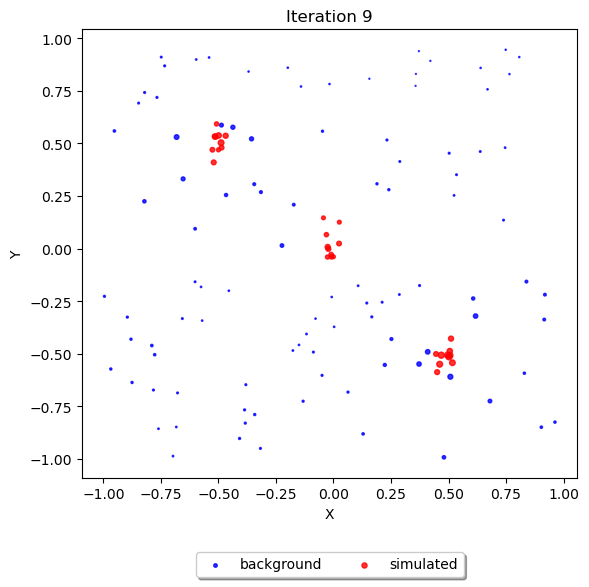

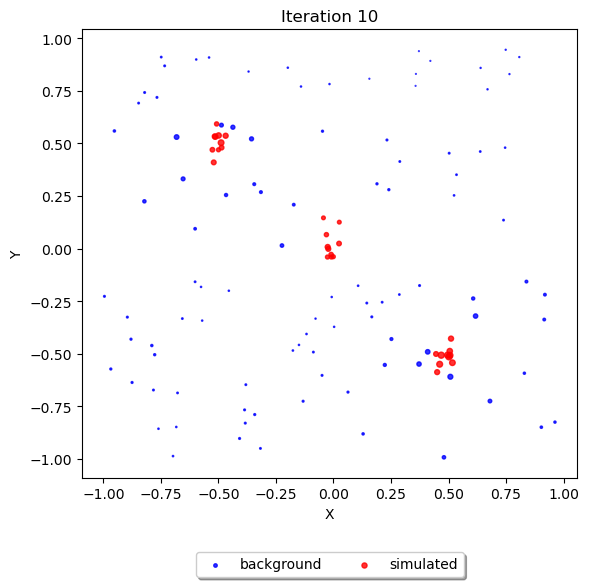

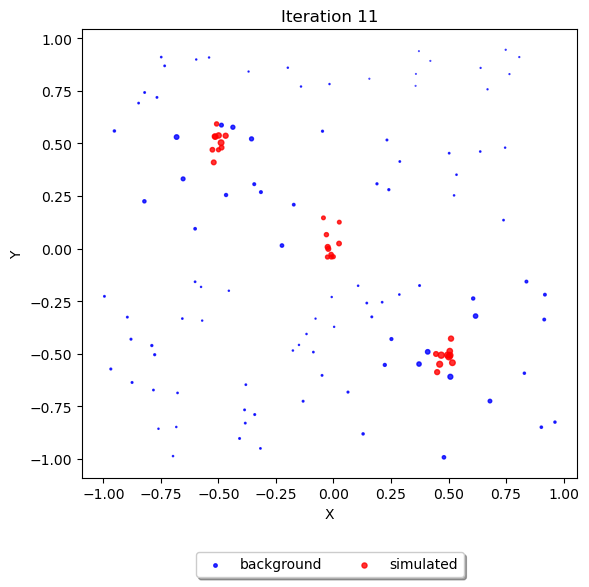

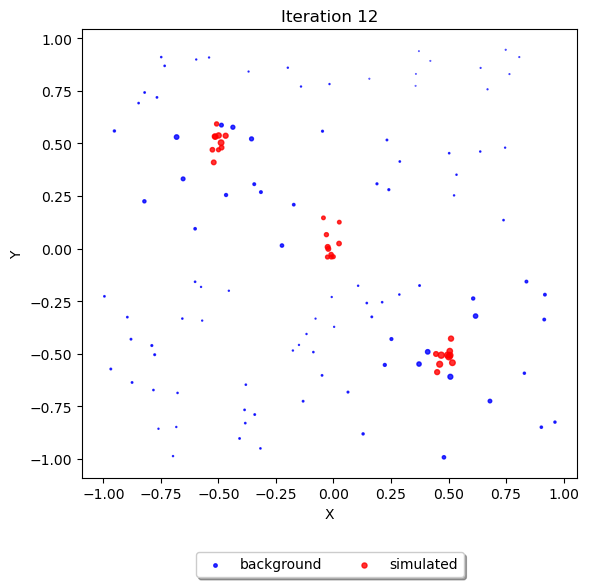

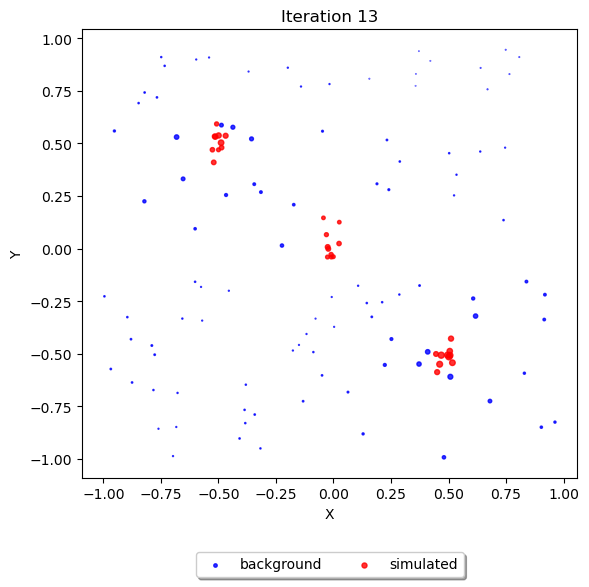

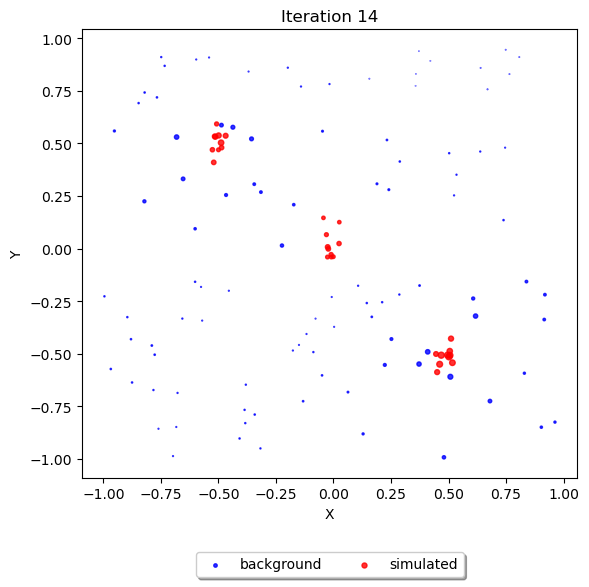

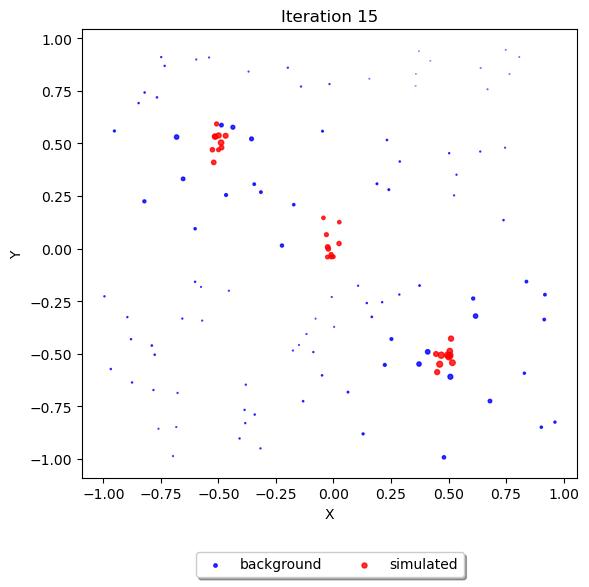

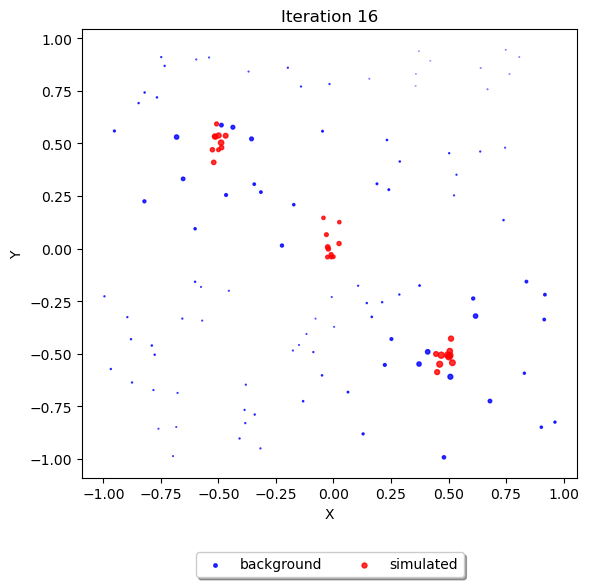

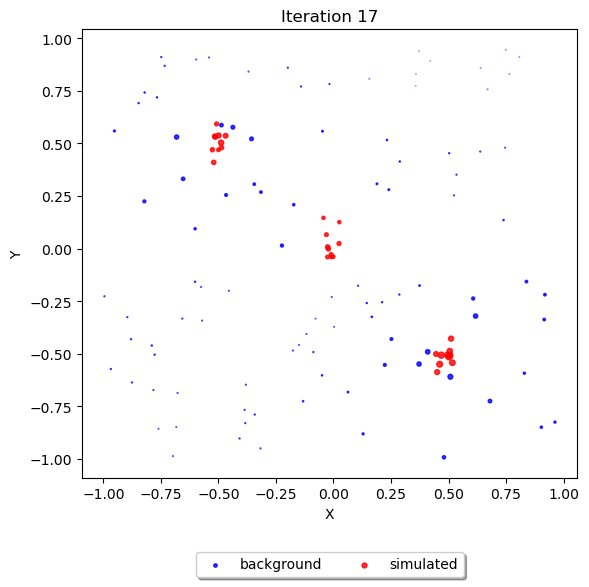

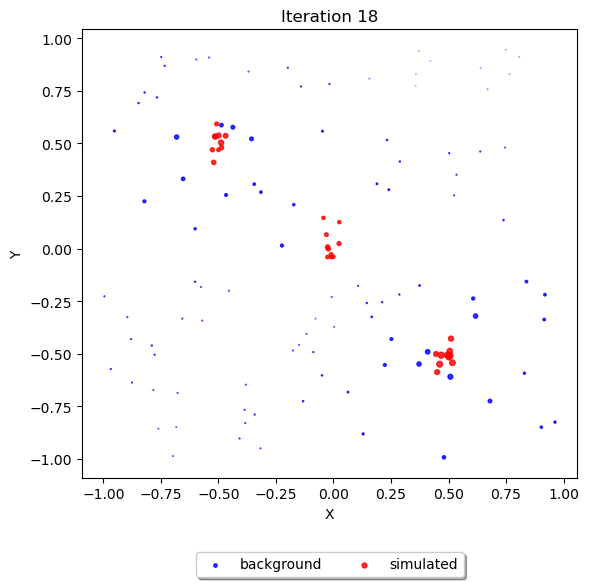

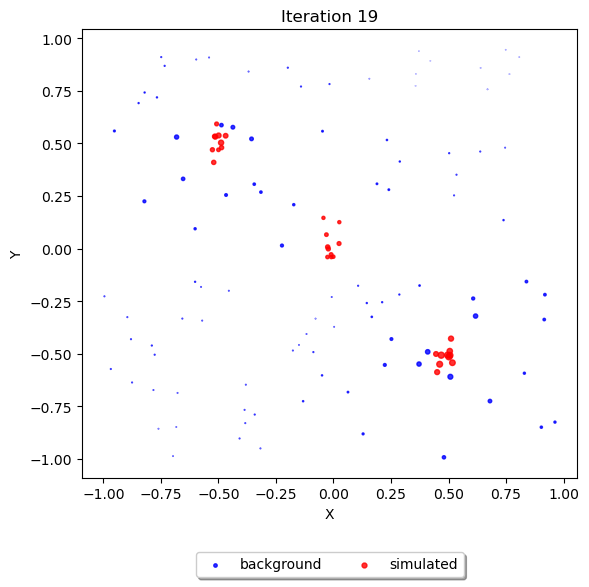

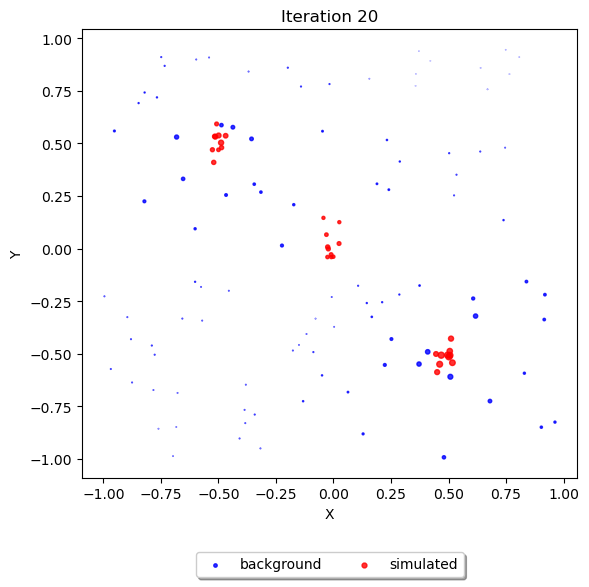

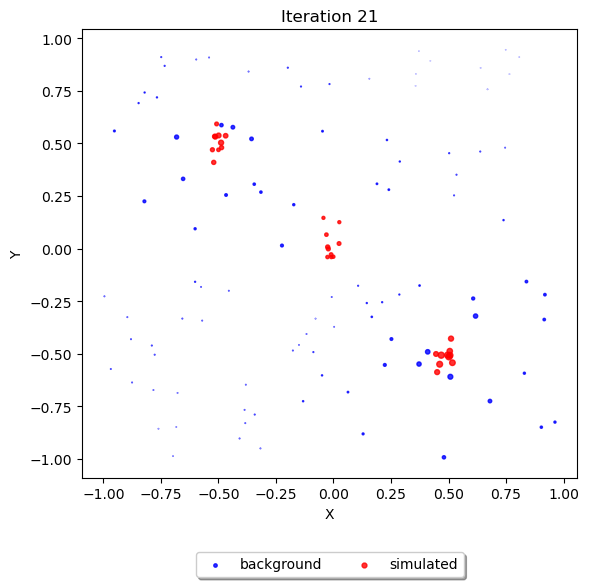

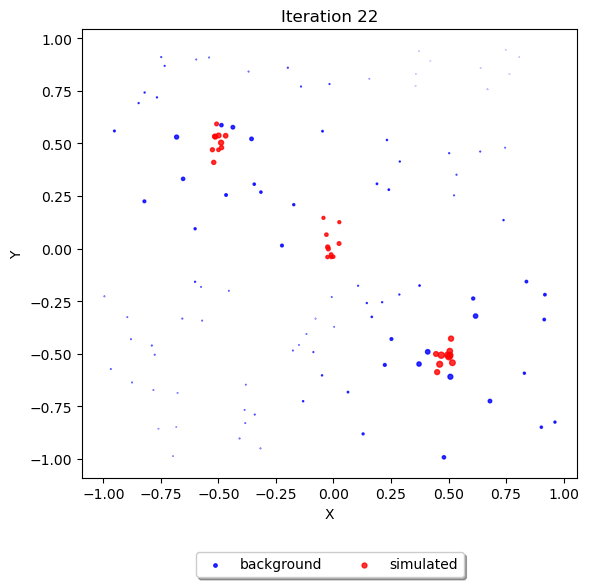

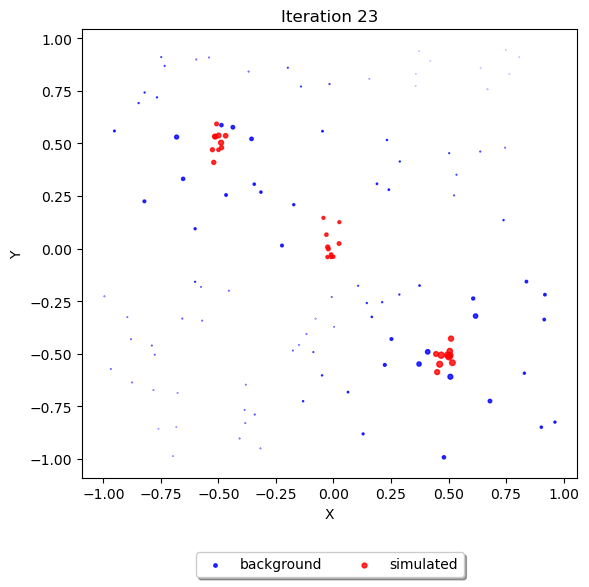

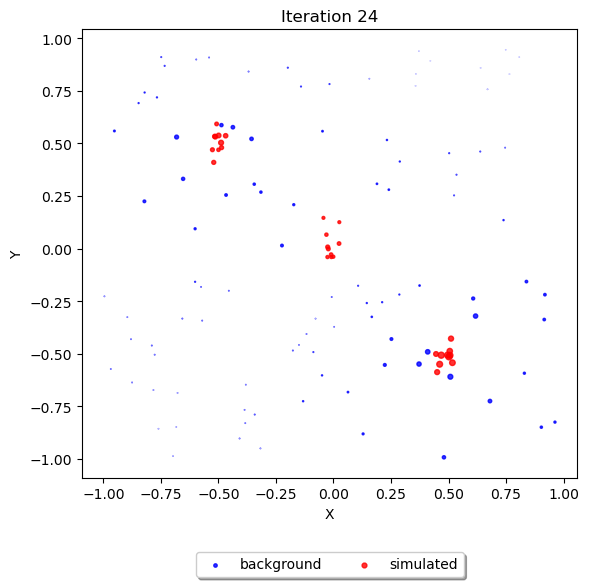

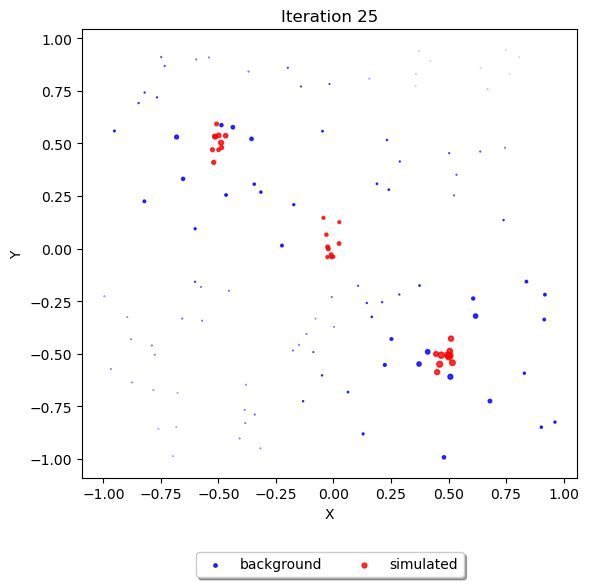

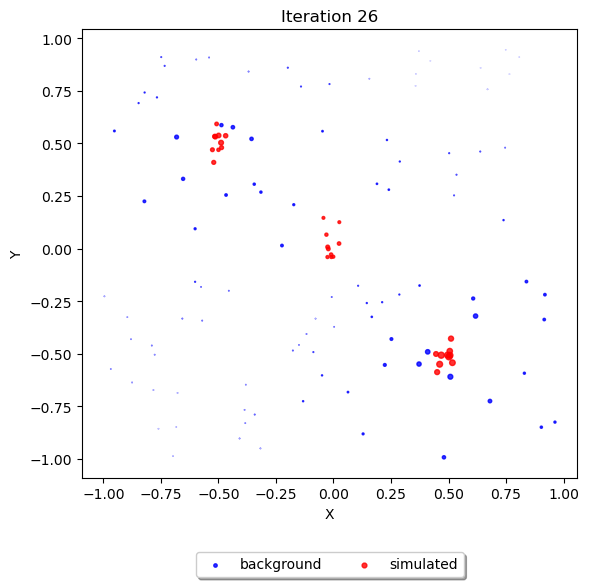

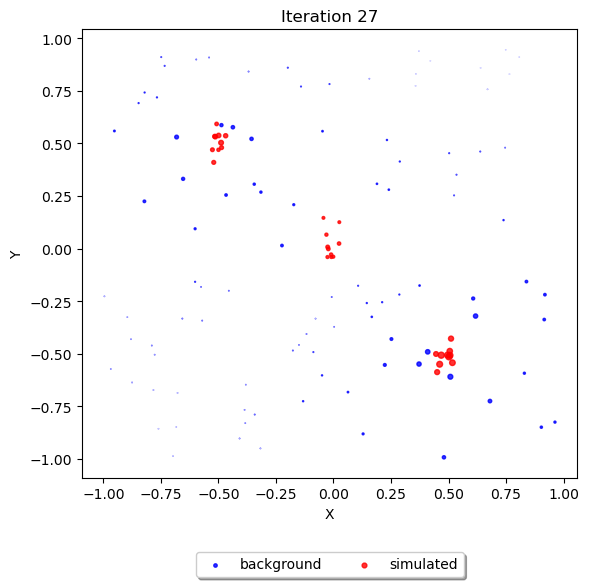

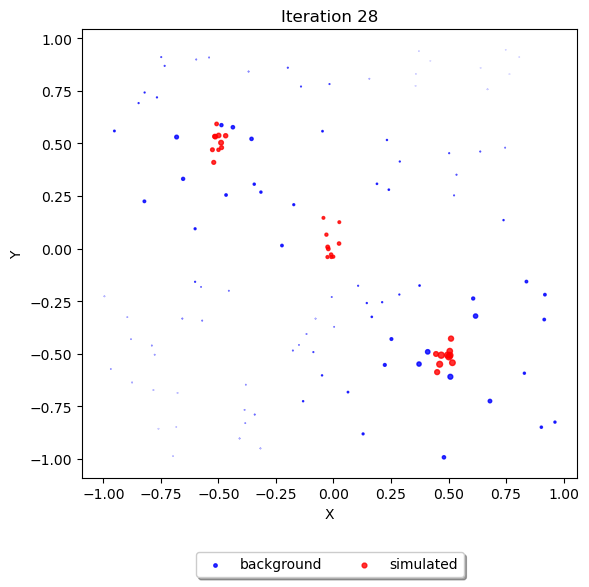

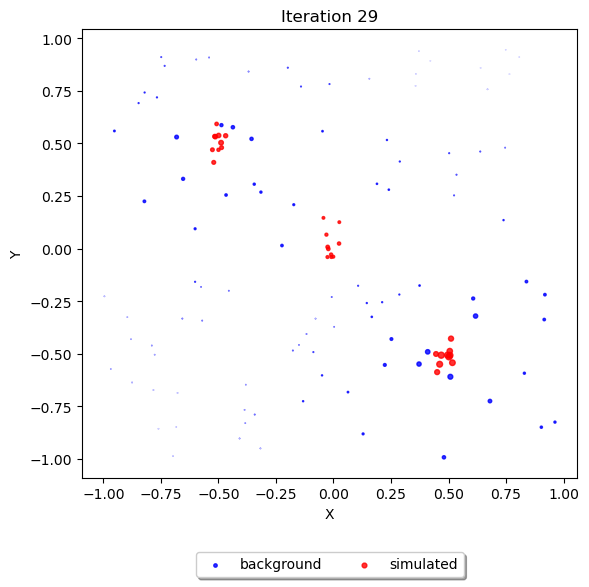

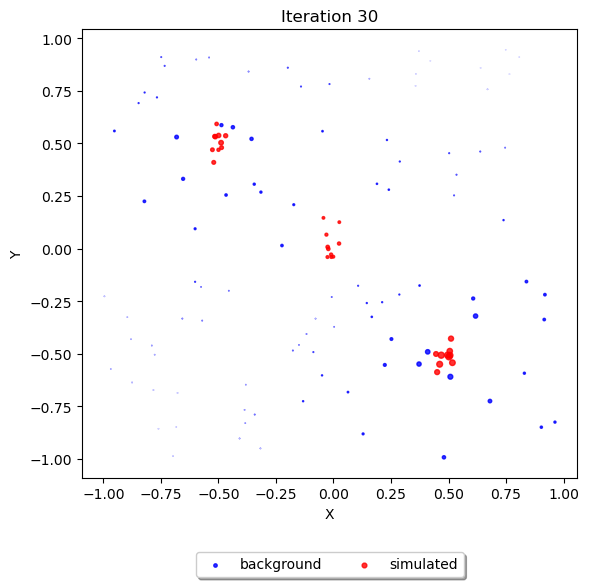

In [9]:
sizes = torch.ones_like(net_data.y)
plot_graph(net_data, sizes*20, "Iteration 0", plot_edges=True, outfile=r"video_frames\frame_{:02}.jpeg".format(0))
plot_graph(net_data, sizes*20, "Iteration 0", plot_edges=plot_edges, outfile=r"video_frames\frame_{:02}.jpeg".format(0))
for i in range(layers):
    sizes += model.forward(sizes, net_data.edge_index)
    sizes /= sizes.max()
    if (i+1)%plot_every==0 or i == layers-1:
        plot_graph(net_data, sizes*20, f"Iteration {i+1}", plot_edges=plot_edges, outfile=r"video_frames\frame_{:02}.jpeg".format(i+1))

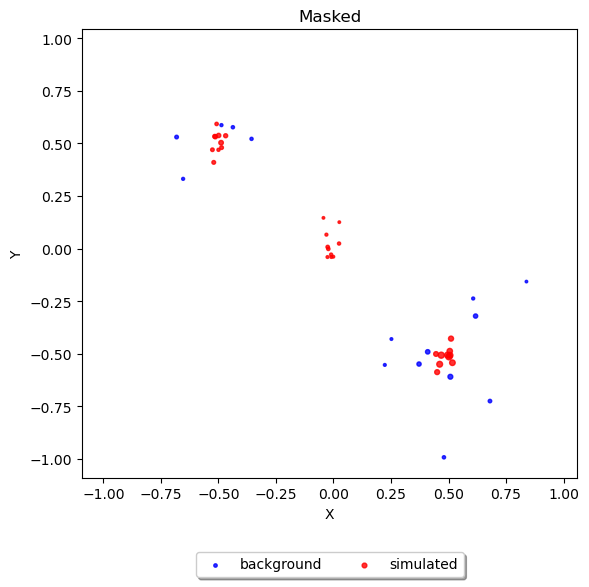

In [ ]:
mask = (sizes > min(sizes.mean().item(), 0.9)).squeeze()
masked_sizes = sizes.clone()
masked_sizes[~mask] = 0
plot_graph(net_data, masked_sizes*20, title="Masked", plot_edges=False, outfile=r"video_frames\masked.jpeg")

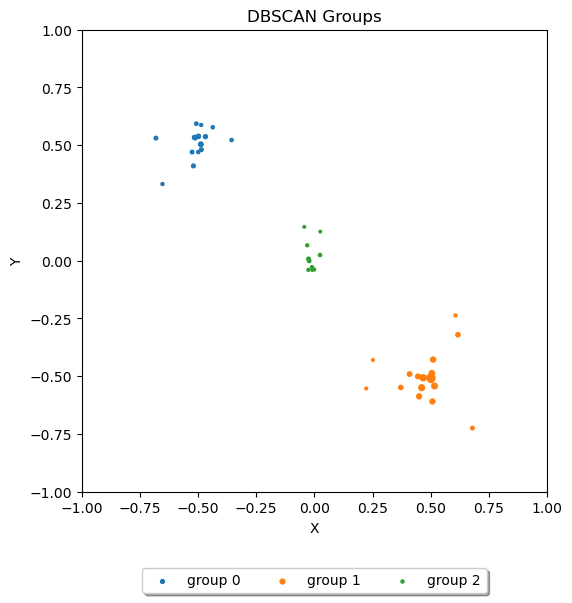

In [ ]:
eps = distances.max().item()/2
dbscan = DBSCAN(eps=eps, min_samples=5)
masked_pos = data.pos[mask].cpu()
labels = dbscan.fit_predict(masked_pos)
plt.figure(figsize=(6,6))
for label in np.unique(labels):
    if label < 0: continue # ignores orphan points
    label_mask = labels == label
    plt.scatter(*masked_pos[label_mask].T, label=f"group {label}", s=masked_sizes[mask].cpu()[label_mask]*20)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)
plt.title("DBSCAN Groups")
plt.savefig(r"video_frames\groups.jpeg")
plt.show()